In [504]:
import numpy as np
import random
import matplotlib.pyplot as plt
from MyGradUpdated.MyGrad.mygrad.tensor_base import Tensor
from MyGradUpdated.MyGrad.mygrad.nnet.activations import sigmoid, relu
from MyGradUpdated.MyGrad.mygrad.nnet.losses import SoftmaxCrossEntropy
from MyGradUpdated.MyGrad.mygrad.math import log
from MyGradUpdated.MyGrad.mygrad.nnet.layers import dense
import pandas as pd
from itertools import product 

In [212]:
fileName = "divorce.xlsx" #you can change this string file name
data_frame_convert = pd.read_excel(fileName)
parseArray = data_frame_convert.values

train_input = parseArray[:136, :-2]
train_output = parseArray[:136, -2]

test_input = parseArray[136: ,:-2]
test_output = parseArray[136:,-2]

print(test_input.shape)
print(test_output.shape)

(34, 54)
[[ 0.  0.  2. ...,  0.  0.  0.]
 [ 3.  2.  3. ...,  4.  4.  4.]
 [ 3.  3.  3. ...,  2.  2.  2.]
 ..., 
 [ 1.  1.  0. ...,  1.  1.  1.]
 [ 0.  3.  1. ...,  0.  0.  0.]
 [ 0.  1.  2. ...,  3.  2.  1.]]
(34,)


In [358]:
"""Neural Net Functions"""

def he_normal(shape):
    N = shape[0] #gets how many "images" there are or "items"
    scale = 1 / np.sqrt(2*N)
    return np.random.randn(*shape)*scale

def fwd_pass(x, weights_1, bias_1, weights_2, bias_2):
    o1 = relu(dense(x, weights_1.data) + bias_1.data)
    o2 = sigmoid(dense(o1, weights_2.data) + bias_2.data)
    return o2
    
def cross_entropy(p_pred, p_true):
    N = p_pred.shape[0]
    p_logq = (p_true) * log(p_pred)
    return (-1/ N) * p_logq.sum()  
    
def gradient_descent(param, rate):
    print(param.grad)
    
def compute_accuracy(pred, actual):
    #inputs are assumed to be a list
    total = 0
    for i in range(len(pred)):
        if pred[i] == actual[i]:
            total += 1
    return total / len(pred)

def mse(result, actual):
    errors = [(actual - calculated) ** 2 for
              calculated, actual in list(zip(result, actual))]   
    return sum(errors) / len(result)

def rounding(x):
    if x >= 0.9:
        return 1
    return 0

In [495]:
"""Cross Validation"""
iterations = 8000

results = {}
best_mse = float('inf')   # The highest validation accuracy that we have seen so far.
best_loss = []  # list of loss values measured during best training session
best_MSEs = []  # list of validation accuracies measured during best training session
step_size = [1e-7,1e-5,1e-6, 1e-8]
reg_strengths = [1e4,1e3,1e2]
your_various_rate_reg_pairs = product(step_size, reg_strengths)
flag = True
for rate, reg in your_various_rate_reg_pairs:
    #Weights init
    layer_1_weights = Tensor(he_normal((54, 170)))
    #print("WEIGHTS", layer_1_weights)
    bias_1 = Tensor(np.zeros((170,), dtype=layer_1_weights.dtype))
    layer_2_weights = Tensor(he_normal((170, 1)))
    bias_2 = Tensor(np.zeros((1,), dtype=layer_2_weights.dtype))
    params = [layer_1_weights, layer_2_weights, bias_1, bias_2]
    print(rate, reg)
    
    losses = []  # will store loss for each training iteration
    liveMSE = []  # will store training accuracy for each training iteration
    
    for it in range(iterations):
        mask = np.random.choice(len(train_input), size=34, replace=False)
        inputs = train_input[mask]
        truths = train_output[mask]
        
        inputs = Tensor(inputs)
        truths = Tensor(truths)
        
        o1 = relu(dense(inputs, layer_1_weights) + bias_1)
        pred = sigmoid(dense(o1, layer_2_weights) + bias_2)
        reg_term = reg * (layer_2_weights**2).sum() #this is regularlization value, Loss big = bad, loss small = good. 
        #reg is bad when all the parameters are really bad  Try to keep elements in W small so it does not overfit
        loss = cross_entropy(pred, truths) + reg_term 
        #how good are our predictions and are we keeping the weights moderate. 
        loss.backward()
        #gives the gradient/values for W.grad and b.grad
         
        for param in params:
            param.data -= rate*param.grad
        
        # !!! Update model parameters using gradient descent with!!!
        ### with the correct learning rate
        loss.null_gradients()  # this is super important!!
        
        predicted_list = [float(ten.data) for ten in list(pred)]
        #val_list = list(map(rounding, list(pred)))       
        #train_accuracy = compute_accuracy(val_list, truths.data.tolist())
        # the accuracy for this training batch
        current_mse = mse(predicted_list, truths.data.tolist())
        liveMSE.append(current_mse)
        losses.append(loss.data.item())
       
    # Training is complete for this hyperparameter configuration
    
    # Use your trained model parameters to compute the predicted scores
    # on the training data. Use this to compute the training-accuracy.
    # save this to `train_acc`
    
    train_predict = fwd_pass(train_input, layer_1_weights, bias_1, layer_2_weights, bias_2)
    predicted_list = [float(ten.data) for ten in list(train_predict)]
    #what if you gradiented instead
    """for i, tensor in enumerate(predicted_list):
        value = 0
        if float(tensor.data) >= 0.95:
            value = 1
        predicted_list[i] = value
    """    
    #train_acc = compute_accuracy(predicted_list, train_output.tolist())
    train_mse = mse(predicted_list, train_output.tolist())

    # Use your trained model parameters to compute the predicted scores
    # on the validation data. Use this to compute the training-accuracy.
    # save this to `val_acc`
    
    val_predict = fwd_pass(test_input, layer_1_weights, bias_1, layer_2_weights, bias_2)
    val_list = [float(ten.data) for ten in list(val_predict)]
    """for i, tensor in enumerate(val_list):
        value = 0
        if float(tensor.data) >= 0.95:
            value = 1
        val_list[i] = value
        """
        
    #val_acc = compute_accuracy(val_list, test_output.tolist())
    val_mse = mse(val_list, train_output.tolist())
        
    results[(rate, reg)] = (train_mse, val_mse)
    if best_mse > val_mse:
        best_loss = losses
        best_MSEs = liveMSE
        best_mse = val_mse
        best_train = train_acc
print(results)

1e-07 10000.0


KeyboardInterrupt: 

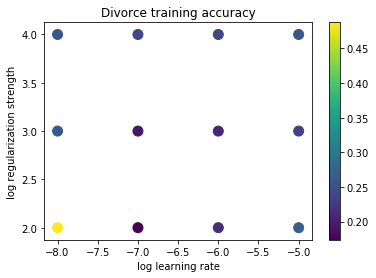

In [384]:
# Visualize the cross-validation results
import matplotlib.cm as cm
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
#plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=cm.viridis)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Divorce training accuracy')
plt.show()

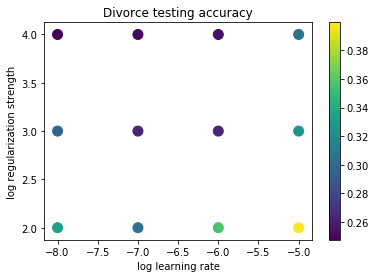

In [388]:
# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
#plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors,  cmap=cm.viridis)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title("Divorce testing accuracy")
plt.show()

In [522]:
"""Hyperparameters: Stepsize = 1e-6.  Regularization = 1000"""
layer_1_weights = Tensor(he_normal((54, 170)))
bias_1 = Tensor(np.zeros((170,), dtype=layer_1_weights.dtype))
layer_2_weights = Tensor(he_normal((170, 1)))
bias_2 = Tensor(np.zeros((1,), dtype=layer_2_weights.dtype))
params = [layer_1_weights, layer_2_weights, bias_1, bias_2]

rate = 1e-7
reg = 1000

iterations = 20000

liveMSE = []
losses = []

for it in range(iterations):
    if (it % 1000 == 0):
        print(it)
        
    inputs = Tensor(train_input)
    truths = Tensor(train_output)

    o1 = relu(dense(inputs, layer_1_weights) + bias_1)
    pred = sigmoid(dense(o1, layer_2_weights) + bias_2)
    reg_term = reg * (layer_2_weights**2).sum() #this is regularlization value, Loss big = bad, loss small = good. 
    #reg is bad when all the parameters are really bad  Try to keep elements in W small so it does not overfit
    loss = cross_entropy(pred, truths) + reg_term 
    #how good are our predictions and are we keeping the weights moderate. 
    loss.backward()
    #gives the gradient/values for W.grad and b.grad

    for param in params:
        param.data -= rate*param.grad

    # !!! Update model parameters using gradient descent with!!!
    ### with the correct learning rate
    loss.null_gradients()  # this is super important!!

    predicted_list = [float(ten.data) for ten in list(pred)]
    #val_list = list(map(rounding, list(pred)))       
    #train_accuracy = compute_accuracy(val_list, truths.data.tolist())
    # the accuracy for this training batch
    current_mse = mse(predicted_list, truths.data.tolist())
    liveMSE.append(current_mse)
    losses.append(loss.data.item())

print("test_input", test_input[10])
test_result = fwd_pass(Tensor(test_input), layer_1_weights, bias_1, layer_2_weights, bias_2)
print("test_output", test_result[10])
print("should be greater than 0.75 and divorced")
test_list = [float(ten.data) for ten in list(test_result)]
final_mse = mse(test_list, test_output.tolist())

print("model's MSE on test data", final_mse)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
test_input [ 2.  0.  2.  4.  2.  2.  4.  3.  4.  3.  2.  3.  3.  0.  4.  4.  3.  3.
  3.  2.  2.  1.  2.  0.  0.  0.  0.  0.  2.  2.  3.  3.  3.  3.  3.  3.
  3.  3.  1.  3.  2.  3.  3.  4.  4.  2.  3.  2.  2.  3.  3.  4.  2.  2.]
test_output Tensor([ 0.79401171])
should be greater than 0.75 and divorced
model's MSE on test data 0.25248242084612965


In [523]:
print("test_input", test_input[31])
test_result = fwd_pass(Tensor(test_input), layer_1_weights, bias_1, layer_2_weights, bias_2)
print("test_output", test_result[31])
if ((float(test_result[31].data))>0.75):
    print("divorce")
else:
    print("safe")
test_list = [float(ten.data) for ten in list(test_result)]
final_mse = mse(test_list, test_output.tolist())

print("model's MSE on test data", final_mse)

test_input [ 1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  2.  0.  2.  1.  0.  0.  1.  1.  1.  1.  1.  1.]
test_output Tensor([ 0.58871674])
safe
model's MSE on test data 0.25248242084612965


In [524]:
outputs = []
test_result = fwd_pass(Tensor(test_input), layer_1_weights, bias_1, layer_2_weights, bias_2)
for prediction in test_result:
    if (float(prediction.data) > 0.75):
        outputs.append(1)
    else:
        outputs.append(0)

total = 0
for i, output in enumerate(outputs):
    if test_output.tolist()[i] == output:
        total += 1
print(total / len(test_output.tolist()))

1.0


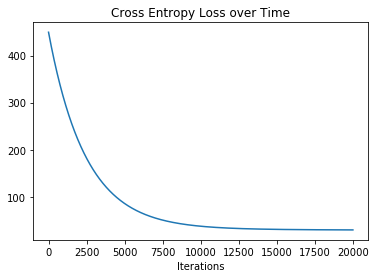

In [525]:
fig,(ax) = plt.subplots(nrows=1)
plt.title("Cross Entropy Loss over Time")
ax.plot(losses)
plt.xlabel('Iterations')
plt.show()

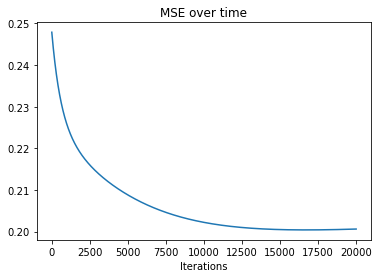

In [526]:
fig,(ax2) = plt.subplots(nrows=1)
plt.title("MSE over time")
ax2.plot(liveMSE)
plt.xlabel('Iterations')
plt.show()

In [527]:
sums = []
for row in layer_1_weights:
    total = 0
    for elem in row.data.tolist():
        total += abs(elem)
    sums.append(total)

print(sums)
print(len(sums))

indices = []
for i, elem in enumerate(sums):
    if elem >= 14:
        indices.append(i+1)
        
print("Important questions", indices)

[13.159393649990534, 13.39700407048173, 13.597904870548694, 12.459210313486047, 12.45202366148654, 12.365851677175316, 13.930288091673273, 12.717665453469143, 12.72688800309134, 11.932938929941205, 13.390138395852992, 13.159274839951763, 12.05387335779299, 13.579935841750515, 13.904926645051466, 13.629355590880694, 13.262468692638787, 12.340571063492007, 14.999516524667989, 13.50345122080811, 11.781294579115283, 12.302547299752451, 14.194835325325432, 12.787260344286652, 12.736773599859319, 13.019334187699425, 14.123177295442783, 12.892240597940015, 13.11880999673165, 12.26351070753626, 13.004937127054404, 11.14147509850699, 14.320960400897862, 13.840840182756505, 12.413350588472213, 12.881773724441171, 12.673430284171758, 13.477933293264595, 14.033692558292023, 12.257522833235344, 13.677266381786769, 14.0125868063202, 13.573869758457583, 14.275803988386317, 12.082886689116487, 13.76410214220024, 12.950271589848345, 13.698096575463117, 12.526730146428854, 12.495113570787478, 14.0950263